# General Social Survey

"The GSS gathers data on contemporary American society in order to monitor and explain trends and constants in attitudes, behaviors, and attributes.  Hundreds of trends have been tracked since 1972. In addition, since the GSS adopted questions from earlier surveys, trends can be followed for up to 80 years.
The GSS contains a standard core of demographic, behavioral, and attitudinal questions, plus topics of special interest. Among the topics covered are civil liberties, crime and violence, intergroup tolerance, morality, national spending priorities, psychological well-being, social mobility, and stress and traumatic events.
Altogether the GSS is the single best source for sociological and attitudinal trend data covering the United States. It allows researchers to examine the structure and functioning of society in general as well as the role played by relevant subgroups and to compare the United States to other nations.
The General Social Survey is an extensive survey conducted on the public of the United States of America every 2 years, to attempt to record the state of society over time." - https://gss.norc.org/about-the-gss

#### Metadata and Variable Translations

Most variables in this dataset are contracted into abbreviated codewords within the Datafile. The __metadata and variable descriptions__ can all be found here: https://sda.berkeley.edu/D3/GSS18/Doc/hcbk.htm, as well as in the accompanying Codebook files (although the website may be easier to navigate). 

The General Social Survey contains a total of over 6000 variables, some of which are only present for a single year (these are known as 'Modules'). Due to the large number of variables, it may be beneficial to start by looking through the website for variables that might be worth comparing (as the variables are grouped on the website).

The set-up of the dataframe for this dataset is slightly more complex, due to the nature in which Pandas imports categorical data (data which can only be of a number of discrete, set values). The data has been codified to numerical format for compression purposes, and this codified data is held in the `data_X.csv` files. The decoding information is held in the `ddi_N.xml` files, and will be needed to translate the numerical data in the main datafiles.

#### Weighting Variables

In some sections of the GSS, certain subgroups are oversampled. For example, although the survey was laid out so that each household in the US had an equal statistical chance of being represented, only one member of each household was selected for the questionnaire, meaning that people from larger households are statistically underrepresented with concern to Personal level variables. In the 1982 and 1987 surveys, Black correspondents were sampled at a higher rate, and thus are overrepresented in the data for these years. Further information on included weighting values and how to compensate for these can be found at the following websites:
* https://sda.berkeley.edu/D3/GSS18/Doc/hcbk.htm
* http://gss.norc.org/Lists/gssFAQs/DispForm.aspx?ID=11

## Starting Questions:
(These are just suggestions, feel free to pursue your own questions)

* What variables are correlated with people's political views?
    - Do people's pets correlate with their political views?
    - Do the amount of siblings people have correlate with their political views?
    - How do these effects compare to those of Age and State?


* How have working hours and conditions changed over time in the US?


* Are more religious people more likely to occupy certain types of jobs?


* Is a person's Occupational Prestige score more correlated to their Father's Occupational Prestige score or their mother's? Is this different in 2010 to 1980?

* Almost 1500 correspondents have been survey at least 30 times (`df['ID'].value_counts().value_counts().sort_index()`). What variables have changed the most within the same correspondent over time?

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
from timeit import default_timer as dtimer
from numpy import NAN
import json

In [9]:
start_time = dtimer()
df = pd.read_csv("data/gss_data_encoded.csv", index_col="CASEID", dtype={"CASEID": str})
end_time = dtimer()
print("Time: {}s".format(round(end_time - start_time, 2)))
df.head()

Time: 147.12s


,YEAR,ID,AGE,SEX,RACE,RACECEN1,RACECEN2,RACECEN3,HISPANIC,RACEHISP,...,RFAMLOOK,OCCONET,SPBARATE,SPGRADTOUNDER,SPEFTOTLT,SECTOR,EFTOTLT,RES2010,RES2008,VOEDNME2
CASEID,,,,,,,,,,,,,,,,,,,,,
1972 1,1972,1,23,2,1,0,0,0,0,9,...,-1,0.0,-1,-1,-1,-1,-1,0,0,0
1972 2,1972,2,70,1,1,0,0,0,0,9,...,-1,0.0,-1,-1,-1,-1,-1,0,0,0
1972 3,1972,3,48,2,1,0,0,0,0,9,...,-1,0.0,-1,-1,-1,-1,-1,0,0,0
1972 4,1972,4,27,2,1,0,0,0,0,9,...,-1,0.0,-1,-1,-1,-1,-1,0,0,0
1972 5,1972,5,61,2,1,0,0,0,0,9,...,-1,0.0,-1,-1,-1,-1,-1,0,0,0


In [11]:
# Load the variable codes
variable_codes = json.load(open("data/gss_data_codes.json", "r"))

# Convert dict keys back into floats, as they will match both float and integer values
for var in variable_codes:
    cvd = variable_codes[var]['categories']
    new_cvd = {}
    for code in cvd:
        new_cvd[float(code)] = cvd[code]
        variable_codes[var]['categories'] = new_cvd

def translate_categories(df, suppress_warning=False, show_missing_values=False, alert_missing_columns=True):
    global variable_codes
    
    # General warning about using this on large DataFrames. Delete if you want.
    if not suppress_warning:
        if len(df.columns) > 100:
            print("Warning: Running this function on large dataframes may take a while.\n" + \
                  "Try running it on a smaller subset of the data for better results.")
        
    for col in df.columns:
        if col not in variable_codes:
            if alert_missing_columns:
                print("The variable '{}' is not included in variable codes. It will not be decoded.")
            continue
        
        categories = variable_codes[col]['categories']
        
        if not show_missing_values:
            for val in variable_codes[col]['missing_values']:
                categories[val] = NAN
        
        df.loc[:, col] = df[col].replace(categories)
    
    return df

def var_name(codename):
    global variable_codes
    return variable_codes[codename]['title']

def var_codes(codename):
    global variable_codes
    return variable_codes[codename]['categories']

def var_question(codename):
    global variable_codes
    return variable_codes[codename]['question_text']

def var_missing_values(codename):
    global variable_codes
    return variable_codes[codename]['missing_values']
    

In [24]:
t1 = dtimer()
test_df = df.iloc[:100][df.columns[:1000]]
# test_vars = df.columns[:102]
tdf = translate_categories(test_df)
t2 = dtimer()
print("Time taken: {}s".format(round(t2-t1, 2)))
# for var in test_vars:
#     print(variable_codes[var])
tdf.head(20)

Try running it on a smaller subset of the data for better results.
Time taken: 6.94s


,YEAR,ID,AGE,SEX,RACE,RACECEN1,RACECEN2,RACECEN3,HISPANIC,RACEHISP,...,UNREL4,HOSDIS5,HOSREL1,HOSREL4,DEATH5,DEATH16,PADEATH,MADEATH,CHLDDTH,SIBDEATH
CASEID,,,,,,,,,,,,,,,,,,,,,
1972 1,1972,1,23,FEMALE,WHITE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972 2,1972,2,70,MALE,WHITE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972 3,1972,3,48,FEMALE,WHITE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972 4,1972,4,27,FEMALE,WHITE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972 5,1972,5,61,FEMALE,WHITE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972 6,1972,6,26,MALE,WHITE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972 7,1972,7,28,MALE,WHITE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972 8,1972,8,27,MALE,WHITE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972 9,1972,9,21,FEMALE,BLACK,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
def time_translate(row_num, col_num):
    print(row_num, col_num)
    test_df = df.iloc[:row_num][df.columns[:col_num]]
    t1 = dtimer()
    tdf = translate_categories(test_df, suppress_warning=True)
    t2 = dtimer()
    return t2-t1

ttimes = [ [(row_num, time_translate(int(10**(row_num/2)), col_num)) for row_num in range(2, 6, 2)] for col_num in range(25, 500, 25) ]    

10 25
100 25
10 50
100 50
10 75
100 75
10 100
100 100
10 125
100 125
10 150
100 150
10 175
100 175
10 200
100 200
10 225
100 225
10 250
100 250
10 275
100 275
10 300
100 300
10 325
100 325
10 350
100 350
10 375
100 375
10 400
100 400
10 425
100 425
10 450
100 450
10 475
100 475


In [25]:
print("Complete")

Complete


In [43]:
print(ttimes)

[[(2, 0.22180920000005244), (3, 0.217879000000039), (4, 0.21128199999998287), (5, 0.2223616999999649)], [(2, 0.36132950000001074), (3, 0.3384049999999661), (4, 0.3688535999999658), (5, 0.3663246999999501)], [(2, 0.4584319999999025), (3, 0.48601209999992534), (4, 0.48717489999989994), (5, 0.5071190999999544)], [(2, 0.6374708999999257), (3, 0.6419144999999844), (4, 0.6498363999999128), (5, 0.6857834999998431)], [(2, 0.7754889999998795), (3, 0.7866782999999486), (4, 0.8056160000001), (5, 0.8720862999998644)], [(2, 1.3036738999999216), (3, 1.3757243000000017), (4, 1.3809317000000192), (5, 1.5238581000000977)], [(2, 1.4285273000000416), (3, 1.4622458999999708), (4, 1.5075883000001795), (5, 1.6330579999998918)], [(2, 1.5063164999999117), (3, 1.5602799000000687), (4, 1.6300693999999112), (5, 1.8940877)], [(2, 1.6728789999999663), (3, 1.7353969000000689), (4, 1.8573612999998659), (5, 2.0401382000000012)]]


2
[25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475] [0.17824360000031447, 0.2517428999999538, 0.3328627000000779, 0.39883800000006886, 0.4666472999997495, 0.5258898999995836, 0.6098315000003822, 0.671003799999653, 0.818439799999851, 0.8671795000000202, 1.023324600000251, 1.4214117000001352, 1.443746000000374, 1.5901652000002287, 1.6305861000000732, 1.7555843000000095, 1.7214529999996557, 1.8126968000001398, 1.9415533999999752]


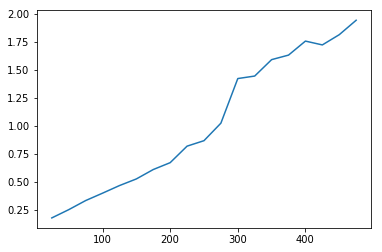

In [56]:
print(len(ttimes[0]))
i = 1
x = list(range(25, 500, 25))
y = [d[i][1] for d in ttimes]
print(x, y)
plt.plot(x, y)

In [18]:
plt.show()

---

In [ ]:
# Load the data for each datafile into a dataframe
df = None
start_time = dtimer()
for filename in os.listdir("data/old_data_and_ddi"):
    if "data_" in filename:
        t1 = dtimer()
        # Had a problem where some CASEID values were importing as numbers, and some as strings, which caused index misalignment
        temp_df = pd.read_csv(os.path.join("data/old_data_and_ddi",filename), index_col="CASEID", dtype={"CASEID": str},
                              na_values=[' ','  ','   ','    '])
        if type(df) == type(None):
            df = temp_df
        else:
            valid_columns = [col for col in temp_df.columns if col not in df.columns]
            sub_df = temp_df[valid_columns]
            df = df.join(sub_df) #, how="outer"
        
        #df = pd.concat([df, temp_df], axis=1)
        t2 = dtimer()
        print("Added {}, time={}s".format(filename, round(t2-t1, 2)))
        
end_time = dtimer()
print("\nComplete. Total time: {}s".format(round(end_time - start_time,2)))
print("{} Variables, {} Columns".format(df.shape[0], df.shape[1]))
df.head()

In [ ]:
def translate_categories(df, show_missing=False):
    global var_dict
    
    for col in df.columns:
        if col not in var_dict:
            print(col)
        else:
            categories = var_dict[col]['categories']
            missing = var_dict[col]['missing_values']
            if not show_missing:
#                 df[col].replace(missing, None, inplace=True)
                df.loc[:, col] = df[col].replace(missing, NAN)
#                 df[col] = df[col].replace(to_replace=missing, value=NAN)
#             df[col].astype(str).replace(categories, inplace=True)
            df.loc[:, col] = df[col].astype(str).replace(categories)
    return df
    
    
    
#     def df_translate_categories(df):
#     global var_dict
    
#     if len(df.columns) > 100:
#         print("Warning: This function should be used on small subsets of the GSS Dataset.\n" + \
#               "Running on large amounts of variables may take a long time.")
    
#     for col in df.columns:
#         if col in var_dict:
#             categories = var_dict[col]['categories']
# #             # Skip over entries with no category labels - nothing needs to be done for these.
# #             if len(categories) == 0:
# #                 continue
#             df[col] = df[col].astype(float).replace(to_replace=categories)
#     return df

In [ ]:
test_vars = ['YEAR','ID','WRKSTAT','INDSTATUS']
tdf = translate_categories(df[test_vars])
for var in test_vars:
    print(var_dict[var])

In [ ]:
tdf

In [ ]:
var_dict

In [ ]:
# compile variable dictionaries

var_dict = {}

for filename in os.listdir("data/old_data_and_ddi"):
    if "ddi_" in filename:
        filepath = os.path.join("data/old_data_and_ddi", filename)
        root = ET.parse(filepath)
        data = root.find("dataDscr")
        
        temp_var_dict = {}
        for var in data:
            # Get the ID Code of the variable
            id_code = var.get("ID")
            # Get the Full Name of the variable
            full_title = var.find("./labl").text.strip()
            # Get the Question Text (if applicable)
            qstn = var.find("qstn")
            if qstn != None:
                question_text = qstn.find("qstnLit").text.strip()
            else:
                question_text = None
            # Get the category labels
            category_dict = {}
            missing_values = []
            category_list = var.findall("catgry")
            for category in category_list:
                value = float(category.find("catValu").text.strip())
                label = category.find("*[@level='category']").text.strip()
                missing = category.get("missing")
                if missing == "Y":
                    missing_values.append(value)
                category_dict[value] = label
                
            temp_var_dict[id_code] = {
                "title": full_title,
                "question_text": question_text,
                "categories": category_dict,
                "missing_values": missing_values
            }
        
            var_dict.update(temp_var_dict)

print("{} variables found.".format(len(var_dict)))
            
def df_translate_categories(df):
    global var_dict
    
    if len(df.columns) > 100:
        print("Warning: This function should be used on small subsets of the GSS Dataset.\n" + \
              "Running on large amounts of variables may take a long time.")
    
    for col in df.columns:
        if col in var_dict:
            categories = var_dict[col]['categories']
#             # Skip over entries with no category labels - nothing needs to be done for these.
#             if len(categories) == 0:
#                 continue
            df[col] = df[col].astype(float).replace(to_replace=categories)
    return df
             
var_dict

In [ ]:
var_dict

In [ ]:
import json
json.dump(var_dict, open("data/data_codes2.json", "w"))

In [ ]:
df.columns[96]

In [ ]:
var_dict['INDSTATUS']

In [ ]:
df = df.loc[:,df.columns.duplicated()]


In [ ]:
df.columns

In [ ]:
t_df = df.copy()

for filename in os.listdir("data"):
    if "ddi_" in filename:
        print("Translating from {}...".format(filename))
        t1 = dtimer()
        filepath = os.path.join("data", filename)
        var_dict = compile_variable_dict(filepath)
        var_count = len(var_dict)
        t2 = dtimer()
        print("{} read. time taken: {}s. variables found: {}".format(filename, round(t2-t1, 2), var_count))
        
        count = 0
        for variable in var_dict:
            count += 1
            if count % 10 == 0:
                print("{} / {}".format(count, var_count))
            categories = var_dict[variable]['categories']
            # Skip over entries with no category labels - nothing needs to be done for these.
            if len(categories) == 0:
                continue
            
            if variable in t_df.columns:
                t_df[variable] = t_df[variable].astype(float).replace(to_replace=categories, inplace=True)
        
        t3 = dtimer()
        print("Translated {}, time={}s".format(filename, round(t3-t2, 2)))
print("Complete.")
df.head()